In [1]:
# imports
import pandas as pd
import os
import seaborn as sns
import numpy as np

from scipy import stats

import matplotlib.pyplot as plt
import matplotlib

from rdkit import Chem
from rdkit.Chem import AllChem

from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.inspection import permutation_importance
from sklearn.decomposition import PCA

In [2]:
data = pd.read_csv('NF_Descriptors.csv')

In [5]:
# get data
data = data.dropna()
y = data['LUMO_calc']
X = data.loc[:, ['Molecular Weight', 'Heavy Atom Molecular Weight', 'Max Absolute Partial Charge', 'Max Partial Charge', 
         'Min Abs Partial Charge', 'Min Partial Charge', 'Radical Electrons', 'Valence Electrons', 'NHOH Count', 'NO Count',
         'H Acceptors', 'H Donors', 'Ring Count', 'Aliphatic Rings', 'Aromatic Rings', 'Saturated Rings', 'Aromatic Carbocycles',
         'Aromatic Heterocycles', 'Heteroatoms', 'Rotatable Bonds', 'Saturated Carbocycles', 'Saturated Heterocycles', 'H Count',
         'C Count', 'N Count', 'F Count', 'Halogen Count', 'Double Bonds', 'Triple Bonds']]
list_numerical = X.columns


# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=10)
scaler = StandardScaler().fit(X_train[list_numerical])
X_train[list_numerical] = scaler.transform(X_train[list_numerical])
X_test[list_numerical] = scaler.transform(X_test[list_numerical])


reg = Lasso(alpha=1)
reg.fit(X_train, y_train)

# R^2 results
print('R squared training set', round(reg.score(X_train, y_train)*100, 2))
print('R squared test set', round(reg.score(X_test, y_test)*100, 2))

# Training data
pred_train = reg.predict(X_train)
mse_train = mean_squared_error(y_train, pred_train)
print('MSE training set', round(mse_train, 2))

# Test data
pred = reg.predict(X_test)
mse_test =mean_squared_error(y_test, pred)
print('MSE test set', round(mse_test, 2))

R squared training set 0.0
R squared test set -0.07
MSE training set 0.3
MSE test set 0.3


/var/folders/5h/fmmpw8js0x33q9xzkn0b94z00000gn/T/ipykernel_9223/2977854018.py:14: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  lr.fit(X_train,y_train)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.165e+03, tolerance: 1.366e+00 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn

[0.09596547 0.09662085 0.10143363 0.10244647 0.10345008 0.10583493
 0.15666371 0.29792582 0.29792582 0.29792582 0.29792582]


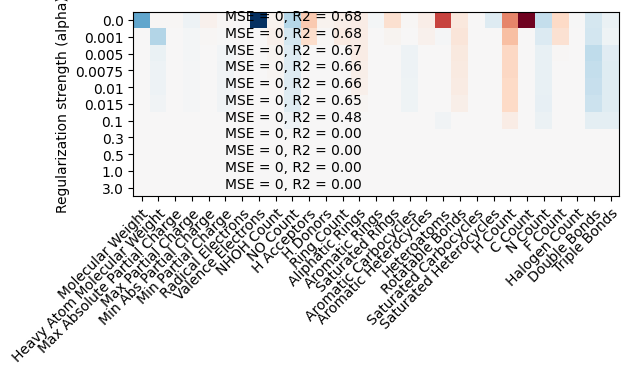

In [6]:
data_labels = list_numerical

alphas = np.array([0, 0.001, 0.005, 0.0075, 0.01, 0.015, 0.1, 0.3, 0.5, 1, 3])
y_pred = np.zeros((alphas.shape[0],y_test.shape[0]))
coeffs = np.zeros((alphas.shape[0],y.shape[0],X.shape[1]),dtype = float)
MSEs = np.zeros(alphas.shape[0])
R2s = np.zeros(alphas.shape[0])
perm_imp = np.zeros((alphas.shape[0],y.shape[0],len(data_labels)))

#Divide into train and test set
for j in range(len(alphas)):

    lr = Lasso(alpha = alphas[j], max_iter=100000) #default = 1000
    lr.fit(X_train,y_train)
    y_pred[j] = lr.predict(X_test)
    coeffs[j] = lr.coef_
    MSEs[j] = mean_squared_error(y_test,y_pred[j])
    R2s[j]  = lr.score(X_train, y_train)

#Plot the results
print(MSEs)
best = 0
for i in range(len(MSEs)):
    if MSEs[i] < MSEs[best]:
        best = i
"""
fig, ax = plt.subplots()
ax.scatter(y, y_pred[best])
ax.plot([0,15],[0,15],color='gray')
ax.annotate("MSE = {:.0f}, R2 = {:.2f}".format(MSEs[best],R2s[best]), xy=(10,20),size=20)
#ax.text(20,10,gpr.kernel_)
ax.set_ylabel("Predicted T80");
ax.set_xlabel("Actual T80");
fig.savefig("Predictions.png")
plt.show()
"""
##Print a 2D plot of the average coefficients
#matplotlib.rcParams['font.size'] = 14.0
ave_coeffs = np.average(coeffs, axis = 1)
min_coeff = np.amin(ave_coeffs)
max_coeff = np.amax(ave_coeffs)
if -min_coeff > max_coeff:
    vmax = -min_coeff
else:
    vmax = max_coeff
fig, ax = plt.subplots()#figsize=(6,3))
im = ax.imshow(ave_coeffs, interpolation="nearest", cmap="RdBu_r",vmax=vmax,vmin=-vmax)
ax.set_xticks(np.arange(len(data_labels)), labels=data_labels)
ax.set_yticks(np.arange(len(alphas)), labels=alphas)
#ax.set_xlabel('')
ax.set_ylabel('Regularization strength (alpha)')
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
for j in range(len(MSEs)):
    ax.text(5,j,"MSE = {:.0f}, R2 = {:.2f}".format(MSEs[j],R2s[j]))
fig.tight_layout()
fig.savefig("NF_LUMOPlot.png")
plt.show()

/var/folders/5h/fmmpw8js0x33q9xzkn0b94z00000gn/T/ipykernel_9223/3232162774.py:33: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  lr.fit(X_train,y_train)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.416e+03, tolerance: 1.649e+00 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn

[0.10409735 0.10582621 0.11135058 0.11506579 0.11669828 0.12040357
 0.17520316 0.32197684 0.35865554 0.35865554 0.35865554]


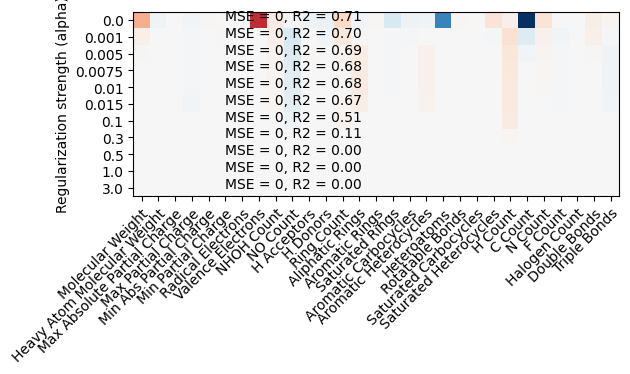

In [8]:
y = data['HOMO_calc']
X = data.loc[:, ['Molecular Weight', 'Heavy Atom Molecular Weight', 'Max Absolute Partial Charge', 'Max Partial Charge', 
         'Min Abs Partial Charge', 'Min Partial Charge', 'Radical Electrons', 'Valence Electrons', 'NHOH Count', 'NO Count',
         'H Acceptors', 'H Donors', 'Ring Count', 'Aliphatic Rings', 'Aromatic Rings', 'Saturated Rings', 'Aromatic Carbocycles',
         'Aromatic Heterocycles', 'Heteroatoms', 'Rotatable Bonds', 'Saturated Carbocycles', 'Saturated Heterocycles', 'H Count',
         'C Count', 'N Count', 'F Count', 'Halogen Count', 'Double Bonds', 'Triple Bonds']]
list_numerical = X.columns


# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=10)
scaler = StandardScaler().fit(X_train[list_numerical])
X_train[list_numerical] = scaler.transform(X_train[list_numerical])
X_test[list_numerical] = scaler.transform(X_test[list_numerical])


reg = Lasso(alpha=1)
reg.fit(X_train, y_train)

data_labels = list_numerical

alphas = np.array([0, 0.001, 0.005, 0.0075, 0.01, 0.015, 0.1, 0.3, 0.5, 1, 3])
y_pred = np.zeros((alphas.shape[0],y_test.shape[0]))
coeffs = np.zeros((alphas.shape[0],y.shape[0],X.shape[1]),dtype = float)
MSEs = np.zeros(alphas.shape[0])
R2s = np.zeros(alphas.shape[0])
perm_imp = np.zeros((alphas.shape[0],y.shape[0],len(data_labels)))

#Divide into train and test set
for j in range(len(alphas)):

    lr = Lasso(alpha = alphas[j], max_iter=100000) #default = 1000
    lr.fit(X_train,y_train)
    y_pred[j] = lr.predict(X_test)
    coeffs[j] = lr.coef_
    MSEs[j] = mean_squared_error(y_test,y_pred[j])
    R2s[j]  = lr.score(X_train, y_train)

#Plot the results
print(MSEs)
best = 0
for i in range(len(MSEs)):
    if MSEs[i] < MSEs[best]:
        best = i
"""
fig, ax = plt.subplots()
ax.scatter(y, y_pred[best])
ax.plot([0,15],[0,15],color='gray')
ax.annotate("MSE = {:.0f}, R2 = {:.2f}".format(MSEs[best],R2s[best]), xy=(10,20),size=20)
#ax.text(20,10,gpr.kernel_)
ax.set_ylabel("Predicted T80");
ax.set_xlabel("Actual T80");
fig.savefig("Predictions.png")
plt.show()
"""
##Print a 2D plot of the average coefficients
#matplotlib.rcParams['font.size'] = 14.0
ave_coeffs = np.average(coeffs, axis = 1)
min_coeff = np.amin(ave_coeffs)
max_coeff = np.amax(ave_coeffs)
if -min_coeff > max_coeff:
    vmax = -min_coeff
else:
    vmax = max_coeff
fig, ax = plt.subplots()#figsize=(6,3))
im = ax.imshow(ave_coeffs, interpolation="nearest", cmap="RdBu_r",vmax=vmax,vmin=-vmax)
ax.set_xticks(np.arange(len(data_labels)), labels=data_labels)
ax.set_yticks(np.arange(len(alphas)), labels=alphas)
#ax.set_xlabel('')
ax.set_ylabel('Regularization strength (alpha)')
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
for j in range(len(MSEs)):
    ax.text(5,j,"MSE = {:.0f}, R2 = {:.2f}".format(MSEs[j],R2s[j]))
fig.tight_layout()
fig.savefig("NF_HOMOPlot.png")
plt.show()

In [9]:
print('R squared training set', round(reg.score(X_train, y_train)*100, 2))
print('R squared test set', round(reg.score(X_test, y_test)*100, 2))

# Training data
pred_train = reg.predict(X_train)
mse_train = mean_squared_error(y_train, pred_train)
print('MSE training set', round(mse_train, 2))

# Test data
pred = reg.predict(X_test)
mse_test =mean_squared_error(y_test, pred)
print('MSE test set', round(mse_test, 2))

R squared training set 0.0
R squared test set -0.07
MSE training set 0.36
MSE test set 0.36


In [10]:
#Step-1
X_meaned = StandardScaler().fit_transform(X)

#Step-2
cov_mat = np.cov(X_meaned , rowvar = False)

#Step-3
eigen_values , eigen_vectors = np.linalg.eigh(cov_mat)

#Step-4
sorted_index = np.argsort(eigen_values)[::-1]
sorted_eigenvalue = eigen_values[sorted_index] # sort eigenvectors -> most important on top (pc1, pc2)
sorted_eigenvectors = eigen_vectors[:,sorted_index] # match eigenvalues to eigenvectors

#Step-5
eigenvector_subset = sorted_eigenvectors[:,0:2]

#Step-6
X_reduced = np.dot(eigenvector_subset.transpose() , X_meaned.transpose() ).transpose()

In [11]:
sort_idx = np.argsort(abs(sorted_eigenvectors))[::-1] # sort by most important features
for line in sort_idx:
    print(*line)

27 26 28 25 24 23 22 21 20 0 8 10 12 19 4 16 2 1 17 14 15 11 3 13 7 18 5 9 6
27 26 25 28 24 23 21 22 20 19 6 4 14 3 13 8 16 0 17 7 18 5 2 9 10 15 1 12 11
20 27 6 26 19 23 28 3 18 2 1 0 15 21 8 14 22 7 12 5 11 9 25 13 16 17 10 4 24
20 27 6 28 19 3 26 18 2 1 0 15 21 8 14 7 25 12 23 5 11 9 22 13 16 17 10 4 24
27 24 26 20 28 25 23 21 22 1 19 18 17 0 2 9 4 6 13 7 14 12 8 5 16 11 10 3 15
27 20 24 17 26 28 4 10 25 6 11 23 14 21 9 7 15 5 13 2 16 22 12 3 1 8 0 18 19
27 20 24 1 26 28 21 25 5 10 23 7 22 12 16 19 15 13 9 3 4 8 6 17 0 2 14 18 11
21 20 27 19 16 22 11 12 17 18 24 4 23 15 28 14 13 0 3 7 8 25 10 5 6 1 2 9 26
14 18 0 1 4 2 3 5 6 10 7 8 9 12 11 13 16 15 17 21 19 20 22 28 24 23 25 26 27
27 25 28 26 24 23 22 21 20 19 10 17 1 16 15 5 6 4 18 11 3 0 9 13 2 14 8 12 7
27 20 24 6 26 5 7 28 25 11 15 10 9 12 8 13 1 17 14 23 2 0 21 16 4 3 18 22 19
21 20 27 24 19 17 16 25 26 9 0 6 18 14 11 15 23 22 8 7 4 13 3 1 10 2 5 12 28
21 27 20 24 19 14 16 25 26 23 17 2 22 4 13 15 6 8 0 18 1 12 9 5 3 10 11 7 28

In [12]:
from sklearn.decomposition import PCA

# y = energy
list_numerical = X.columns

pca = PCA(n_components = 2)

X = StandardScaler().fit_transform(X)

principal_comp = pca.fit_transform(X)

principal_df = pd.DataFrame(data = principal_comp, columns = ['principal component 1', 'principal component 2'])

final_df = pd.concat([principal_df, y], axis = 1)

explained_variance = pca.explained_variance_ratio_

explained_variance

array([0.21296132, 0.1782438 ])

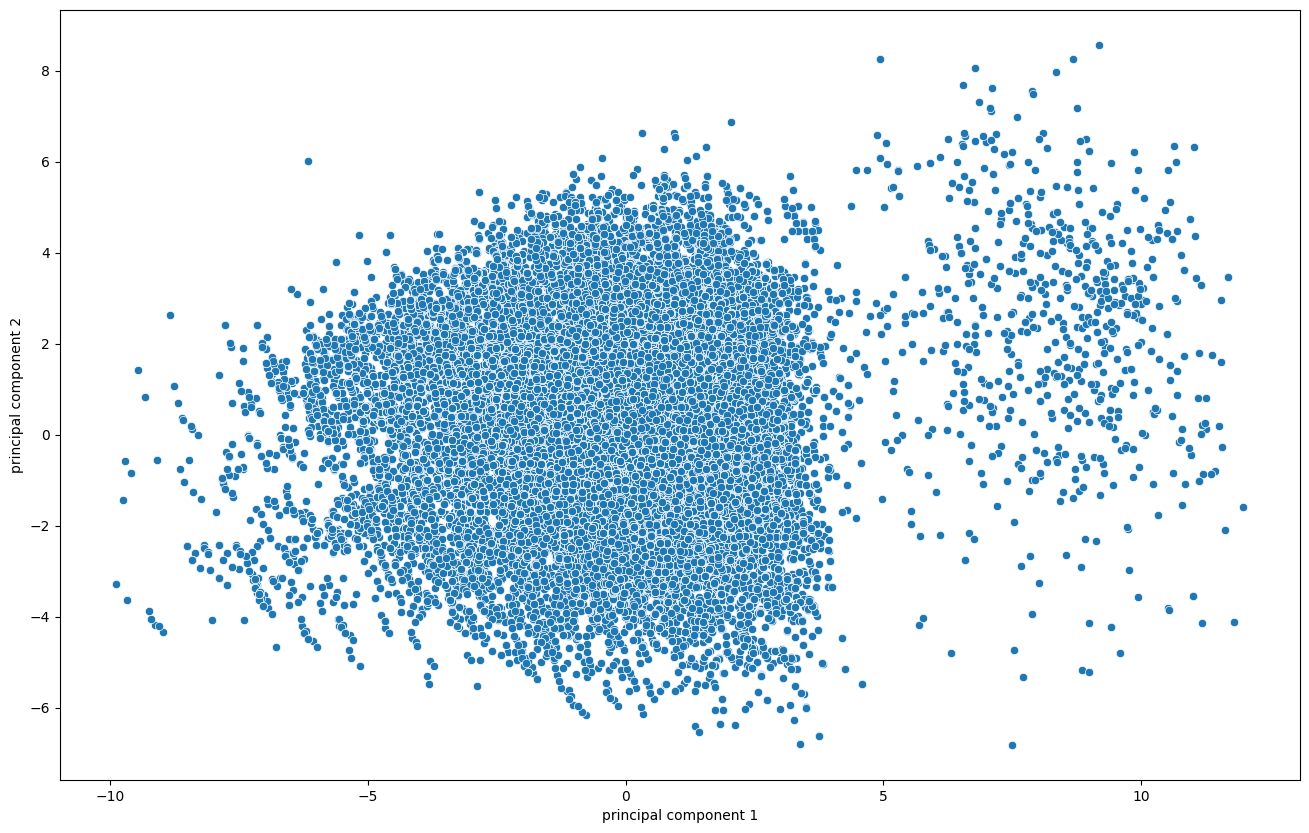

In [13]:
plt.figure(figsize=(16,10))
g = sns.scatterplot(
    x="principal component 1", y="principal component 2", data = final_df
)
figure = g.get_figure()
figure.savefig('NFDataPCA.png', dpi=800)

In [21]:
from sklearn.decomposition import PCA

X = data.loc[:,['F Count', 'Halogen Count', 'Triple Bonds', 'Saturated Carbocycles', 'H Count']]
# y = energy
list_numerical = X.columns

pca = PCA(n_components = 2)

X = StandardScaler().fit_transform(X)

principal_comp = pca.fit_transform(X)

principal_df = pd.DataFrame(data = principal_comp, columns = ['principal component 1', 'principal component 2'])

final_df = pd.concat([principal_df, y], axis = 1)

explained_variance = pca.explained_variance_ratio_

explained_variance

array([0.55460511, 0.2964512 ])

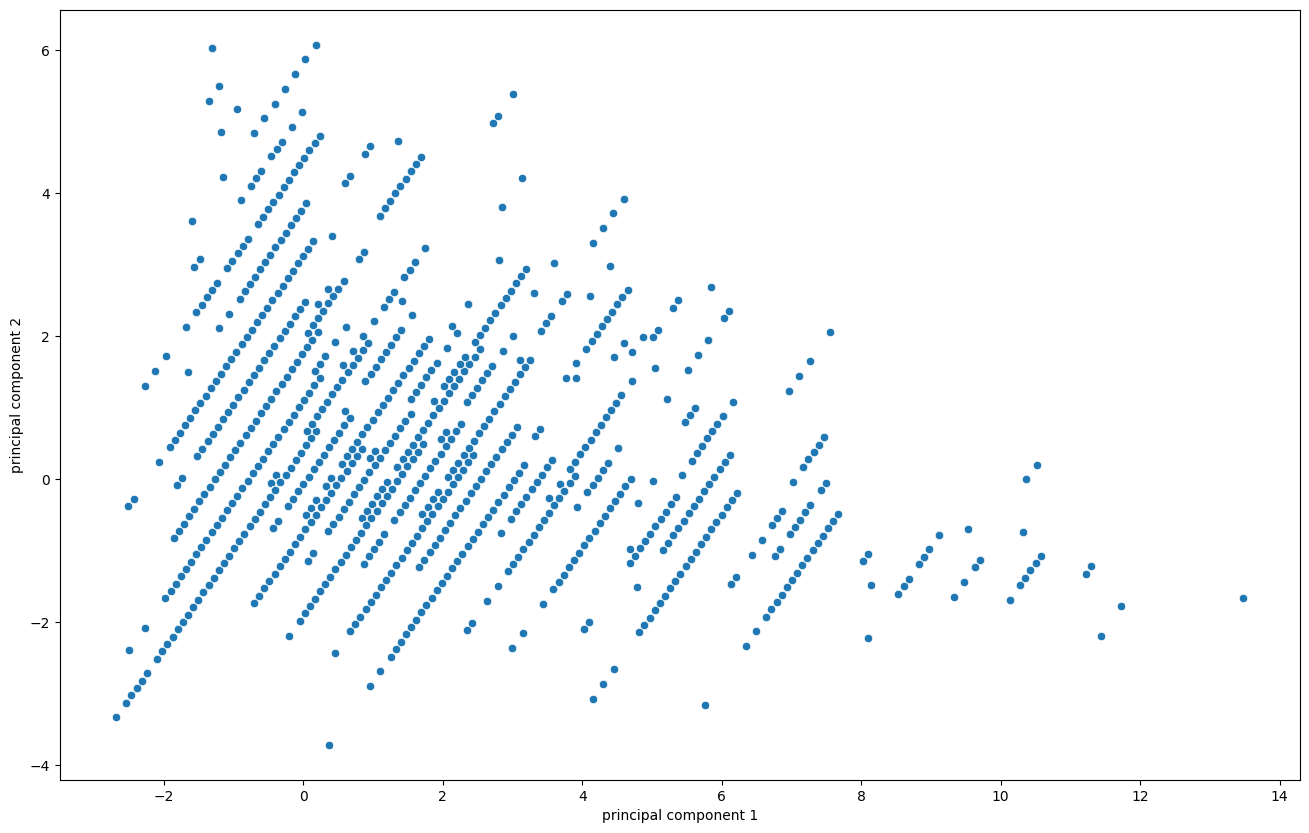

In [15]:
plt.figure(figsize=(16,10))
g = sns.scatterplot(
    x="principal component 1", y="principal component 2", data = final_df
)
figure = g.get_figure()
figure.savefig('NF_DataPCA-Top5.png', dpi=800)

(51256, 38)
   Unnamed: 0                                                                                smiles  HOMO_calc  LUMO_calc  LUMO_calib  LUMO_calib_stds  HOMO_calib  HOMO_calib_stds  Molecular Weight  Heavy Atom Molecular Weight  Max Absolute Partial Charge  Max Partial Charge  Min Abs Partial Charge  Min Partial Charge  Radical Electrons  Valence Electrons  NHOH Count  NO Count  H Acceptors  H Donors  Ring Count  Aliphatic Rings  Aromatic Rings  Saturated Rings  Aromatic Carbocycles  Aromatic Heterocycles  Heteroatoms  Rotatable Bonds  Saturated Carbocycles  Saturated Heterocycles  H Count  C Count  N Count  F Count  Halogen Count  Double Bonds  Triple Bonds                                            mol
0           0    CN1C(=O)C(=Cc2occc2C(=O)c2ccc(-c3ncc(C4=CC=CC5N=C(F)C(F)=NC45)cn3)s2)C(=O)N(C)C1=O  -6.236230  -3.127170   -3.708691         0.272688   -6.310338         0.223776           588.552                      570.408                     0.464170            0.332907

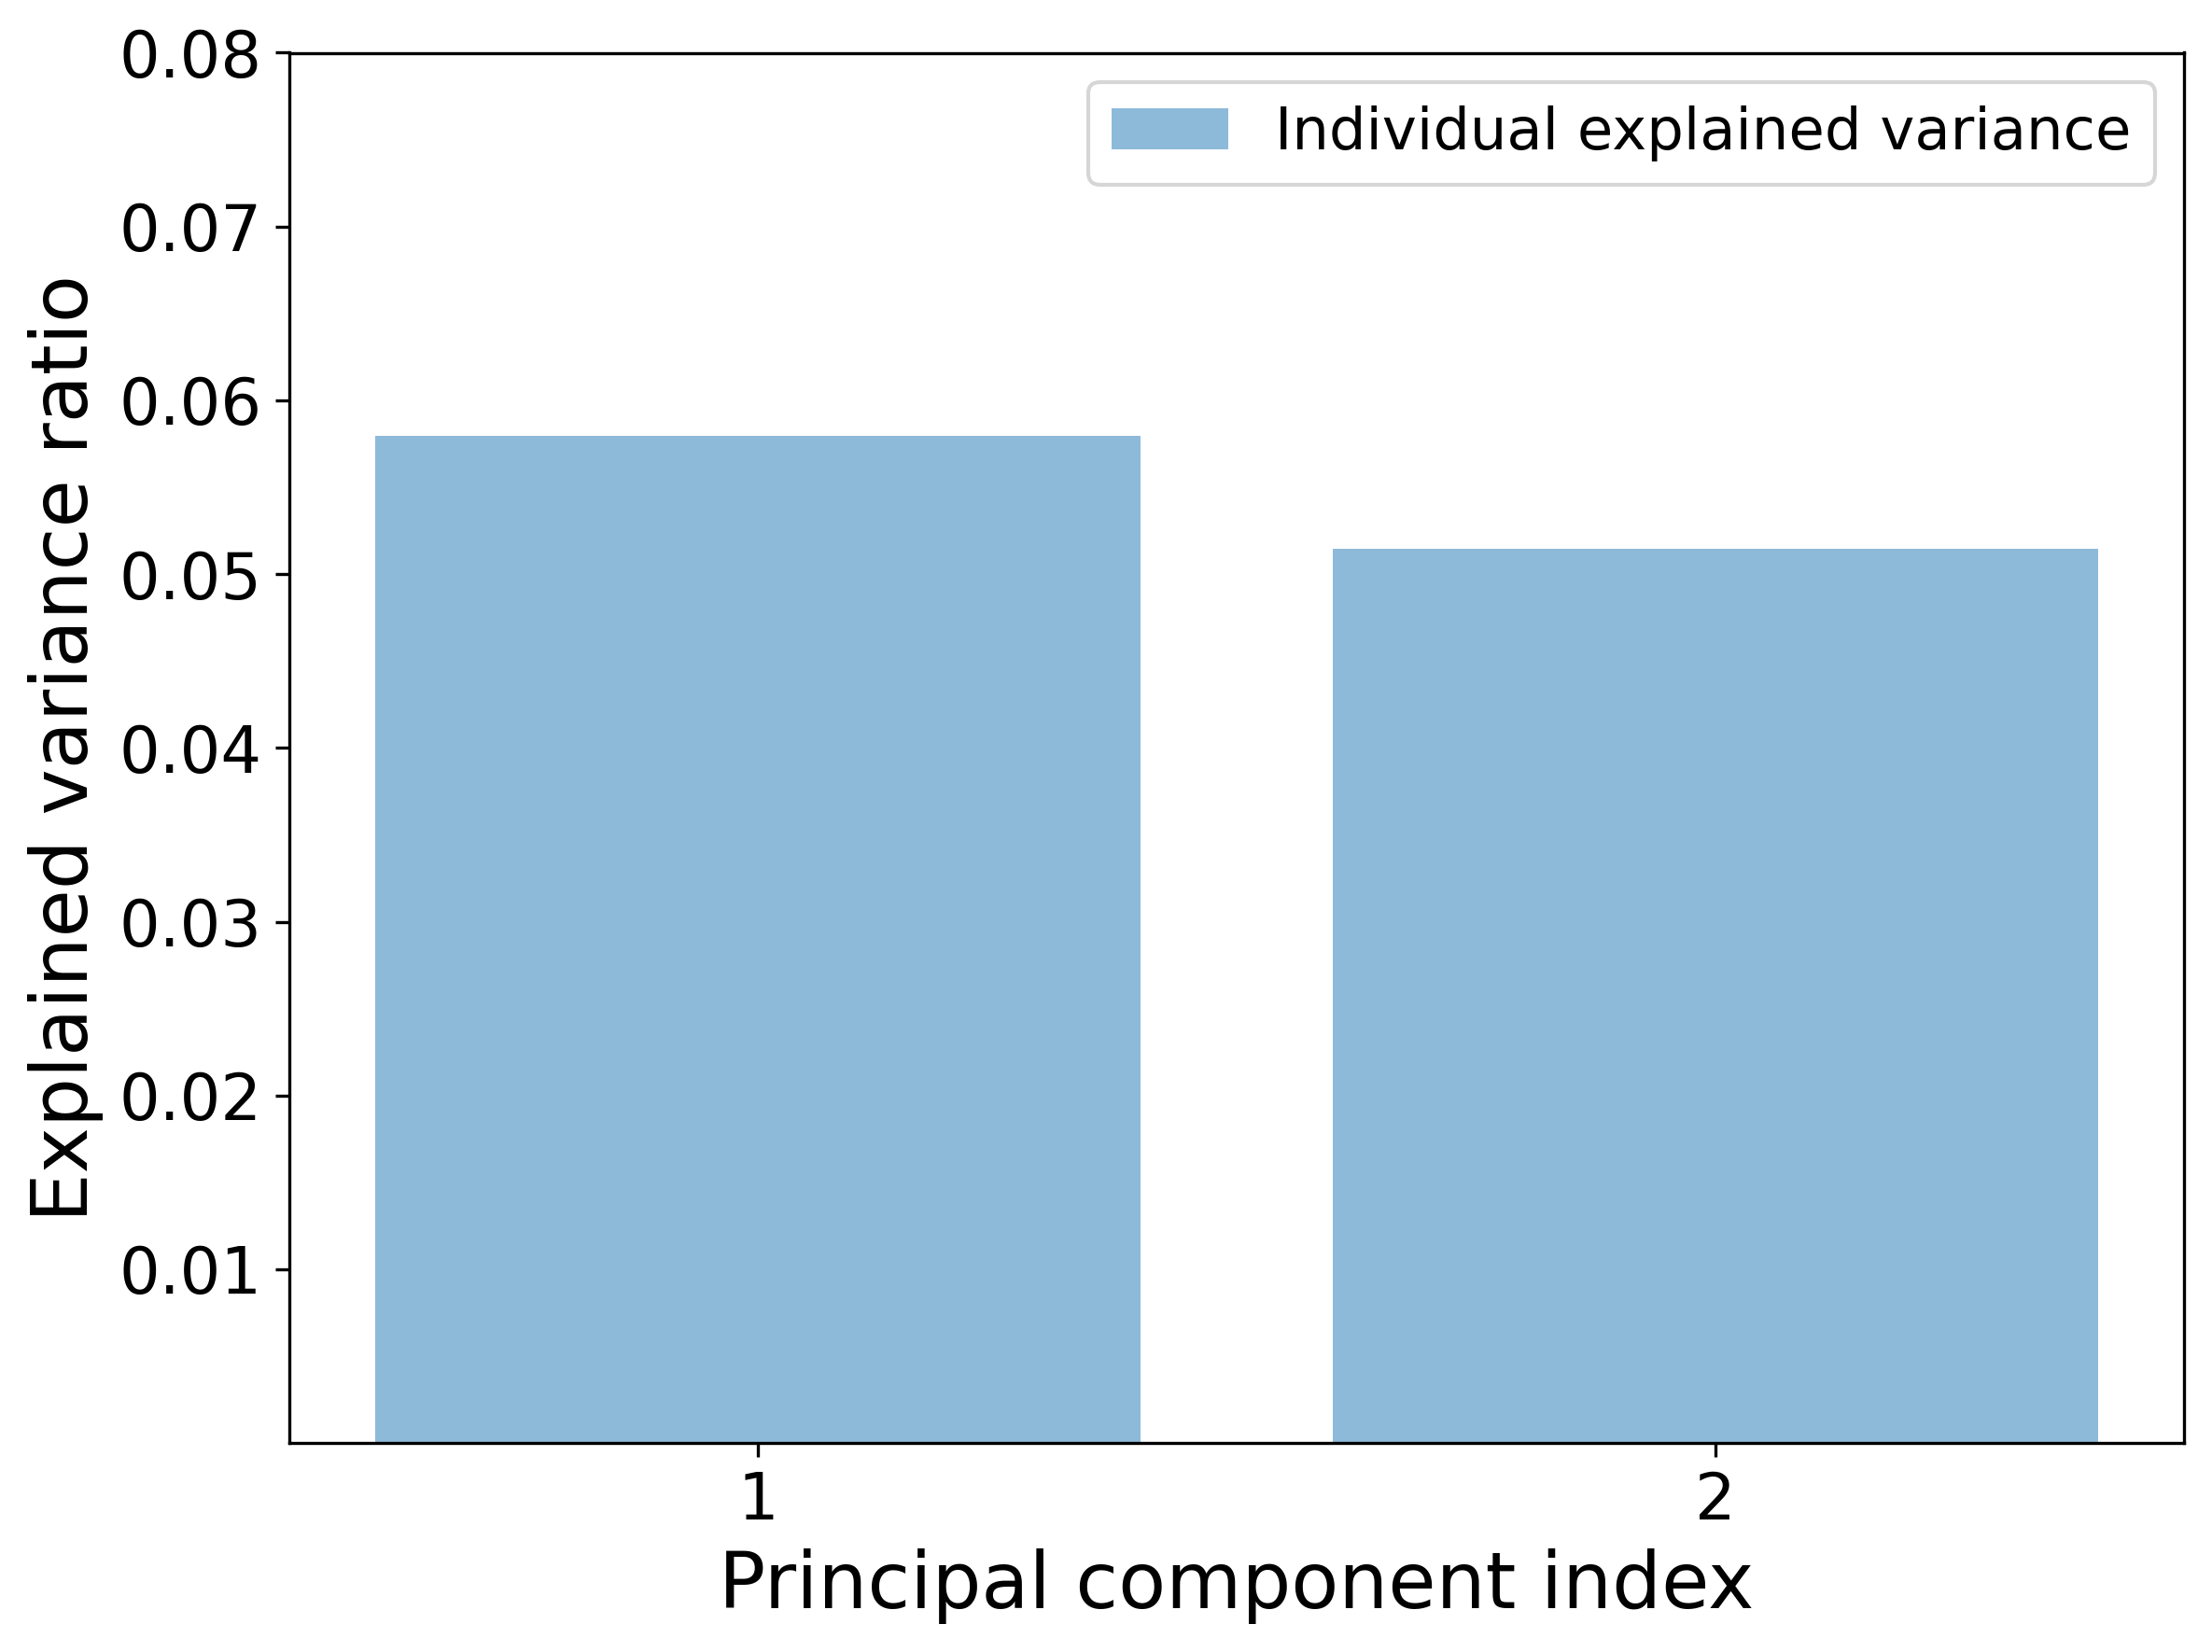

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/var/folders/5h/fmmpw8js0x33q9xzkn0b94z00000gn/T/ipykernel_9223/1422817094.py:99: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for lh in g.ax_joint.legend_.legendHandles:


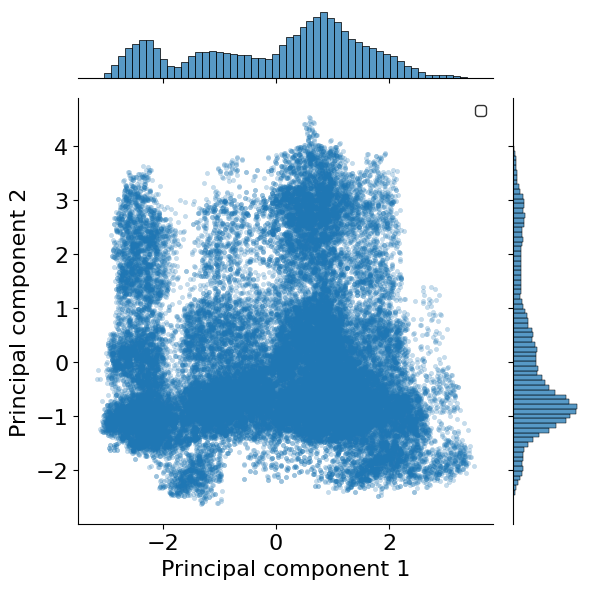

In [23]:
def pca_using_common_axis(target_fps, pca_eigenvector, mean_fps):
    # data = target_fps - np.mean(target_fps, axis=0)
    data = target_fps - mean_fps
    # cov_matrix = data.T.dot(data) / data.shape[0]
    principal_df = pd.DataFrame(data=None, columns=['PC%d' % num for num in range(1, 3)])
    idx = 0
    for eigenvector in pca_eigenvector:
        # get PC coefficient
        idx += 1
        principal_df['PC%d' % idx] = data.dot(eigenvector)
        if idx == 2:
            break

    return principal_df


if __name__ == '__main__':
    # save directory

    # (1) load PolyInfo polymers
    df = pd.read_csv('NF_descriptors.csv')

    # canonical smiles
    df['mol'] = df['smiles'].apply(lambda x: Chem.MolFromSmiles(x))
    df['smiles'] = df['mol'].apply(lambda x: Chem.MolToSmiles(x))
    # df = df.drop(['SMILES'], axis=1)
    # df = df.drop_duplicates(subset='smiles')

    print(df.shape, flush=True)
    print(df.head().to_string(), flush=True)

    # fps of PolyInfo polymers
    fps = np.array(
        df['mol'].apply(lambda x: AllChem.GetMorganFingerprintAsBitVect(x, 2, nBits=1024)).tolist()
    ).astype('float32')

    # (2) load OMG polymers (previous version)
    # fps_OMG = np.load('/home/sk77/PycharmProjects/publish/OMG/data/fps_OMG_polymers_random_2M.npy')
    # print(fps_OMG.shape, flush=True)

    # PCA
    n_components = 2
    pca = PCA(n_components=n_components)
    principal_components = pca.fit_transform(fps)
    polyinfo_mean = np.mean(fps, axis=0)

    principal_df = pd.DataFrame(
        data=principal_components,
        columns=['PC%d' % (num + 1) for num in range(n_components)]
    )

    # plot explained variance by principal component analysis
    exp_var_pca = pca.explained_variance_ratio_
    plt.figure(figsize=(8, 6), dpi=300)
    plt.bar(range(1, len(exp_var_pca) + 1), exp_var_pca, alpha=0.5, align='center',
            label='Individual explained variance')
    plt.xticks(ticks=range(1, len(exp_var_pca) + 1), labels=range(1, len(exp_var_pca) + 1), fontsize=16.5)
    plt.yticks(ticks=[0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08],
               labels=[0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08], fontsize=16.5)
    plt.ylabel('Explained variance ratio', fontsize=20)
    plt.xlabel('Principal component index', fontsize=20)
    plt.legend(loc='best', fontsize=15)
    plt.tight_layout()
    plt.savefig('NF_Explained_ratio_dopants.png')
    plt.show()
    plt.close()

    # # (2) PCA of OMG polymers using PolyInfo polymers PCA
    # principal_df = pca_using_common_axis(target_fps=fps, pca_eigenvector=pca.components_,
    #                                          mean_fps=polyinfo_mean)

    # # construct dataframe for plot
    # # principal_PolyInfo_df['polymer'] = ['PolyInfo'] * principal_PolyInfo_df.shape[0]
    # principal_OMG_df['polymer'] = principal_df.shape[0]

    # sorted_principal_PolyInfo_df = principal_PolyInfo_df.sort_values(by='PC1', ascending=False)
    # # print(sorted_principal_PolyInfo_df.head(50))

    # plot_df = pd.concat([principal_PolyInfo_df, principal_OMG_df], ignore_index=True, axis=0)

    g = sns.jointplot(
        data=principal_df,
        x="PC1",
        y="PC2",
        # hue="polymer",
        kind='scatter',
        joint_kws=dict(alpha=0.25),
        # hue_order=['PolyInfo', 'OMG'],
        # hue_order=['OMG', 'PolyInfo'],
        edgecolor=None,
        palette=['#4DC3C8', '#FF00FF'],  # cyan (#4DC3C8) and magenta (#FF00FF)
        s=10.0,
        marginal_kws={'common_norm': False}
    )
    g.ax_joint.tick_params(labelsize=16)
    legend = g.ax_joint.legend(title=None, fontsize=10, loc='upper right')
    legend.get_frame().set_edgecolor('k')
    legend.get_frame().set_linewidth(1.0)
    for lh in g.ax_joint.legend_.legendHandles:
        lh.set_alpha(0.5)
        lh.set_sizes([5])
    g.set_axis_labels('Principal component 1', 'Principal component 2', fontsize=16)
    g.fig.tight_layout()
    g.fig.savefig('NF_fingerprintsPCA.png', dpi=800)

In [24]:
pca.explained_variance_ratio_

array([0.05792834, 0.05145004], dtype=float32)